## Анализ пользователей по когортам



In [1]:
import pandas as pd
import datetime

import some_funcs
from some_funcs import simple_ch_client, plotly_df, highlight_vals

In [2]:
CH_HOST = 'https://rc1a-rt82aoo61ovjyuxf.mdb.yandexcloud.net:8443'
CH_USER = 'z_sergey'
CH_PASS = open('../.chpass.txt').read().strip()

cacert = 'YandexInternalRootCA.crt'

In [3]:
my_client = simple_ch_client(CH_HOST, CH_USER, CH_PASS, cacert)

In [4]:
start_date = datetime.datetime(2020, 7, 1)
end_date = datetime.datetime(2020, 9, 30)

In [5]:
q = 'DROP TABLE IF EXISTS metrica_data.retention_users'
my_client.get_clickhouse_data(q)

''

In [6]:
q = '''
    CREATE TABLE metrica_data.retention_users ENGINE = Log AS
    Select a.*, b.min_date
    from 
    (
        SELECT ClientID as client_id, toMonday(StartDate) as date, count() as visits, 
            sum(Purchases) as purchases, sum(Revenue) as revenue
        FROM metrica_data.visits
        WHERE (client_id != 0)
        group by client_id, date
    ) as a
    any left join
    (
        SELECT ClientID as client_id, min(toMonday(StartDate)) as min_date
        FROM metrica_data.visits
        WHERE (client_id != 0)
        group by client_id
    
    ) as b
    using (client_id)
'''.format(
    start_date = start_date.strftime('%Y-%m-%d'),
    end_date = end_date.strftime('%Y-%m-%d')
)

my_client.get_clickhouse_data(q)


''

In [7]:
q = '''SELECT count(), uniq(client_id) FROM metrica_data.retention_users FORMAT TabSeparatedWithNames'''
my_client.get_clickhouse_df(q)

,count(),uniq(client_id)
0,347686,298542


In [8]:
q = '''
SELECT 
    client_id,
    min_date, 
    max_date,
    date
FROM
    (
        SELECT
            client_id,
            min(date) as min_date,
            max(date) as max_date
        FROM metrica_data.retention_users
        GROUP BY client_id
        HAVING (min_date <= '{end_date}') AND (min_date >= '{start_date}')
    ) as a
    ALL INNER JOIN
    (
        SELECT 
            client_id,
            date
        FROM metrica_data.retention_users
    ) as b
    USING client_id
LIMIT 10
FORMAT TabSeparatedWithNames
'''.format(
    start_date = start_date.strftime('%Y-%m-%d'),
    end_date = end_date.strftime('%Y-%m-%d')
)

my_client.get_clickhouse_df(q)

,client_id,min_date,max_date,date
0,11346328702551058579,2020-07-13,2020-09-07,2020-07-13
1,11346328702551058579,2020-07-13,2020-09-07,2020-09-07
2,13106442848447404077,2020-09-14,2020-09-14,2020-09-14
3,13041872533683226559,2020-07-27,2020-07-27,2020-07-27
4,14051588439054376991,2020-07-06,2020-07-06,2020-07-06
5,17287937153480005918,2020-09-07,2020-09-07,2020-09-07
6,1880557729445743004,2020-07-27,2020-07-27,2020-07-27
7,1717899126568995497,2020-08-17,2020-08-17,2020-08-17
8,12735858831012285246,2020-09-07,2020-09-07,2020-09-07
9,16757513062212456860,2020-07-20,2020-09-14,2020-09-14


### Простой retention

In [9]:
q = '''
SELECT 
    uniq(client_id) as clients,
    min_date, 
    (date - min_date)/7 as week_num
FROM
    (
        SELECT
            client_id,
            min(date) as min_date,
            max(date) as max_date
        FROM metrica_data.retention_users
        GROUP BY client_id
        HAVING (min_date <= '{end_date}') AND (min_date >= '{start_date}')
    ) as a
    ALL INNER JOIN
    (
        SELECT 
            client_id,
            date
        FROM metrica_data.retention_users
    ) as b
    USING client_id
GROUP BY
    week_num,
    min_date
FORMAT TabSeparatedWithNames
'''.format(
    start_date = start_date.strftime('%Y-%m-%d'),
    end_date = end_date.strftime('%Y-%m-%d')
)

raw_ret_df = my_client.get_clickhouse_df(q)

In [10]:
ret_df = raw_ret_df.pivot_table(index = 'min_date', values = 'clients', columns = 'week_num').fillna(0).T

In [11]:
ret_df_norm = ret_df.apply(lambda x: 100*x/ret_df.loc[0], axis = 1).applymap(lambda x: x if x!=0 else None)

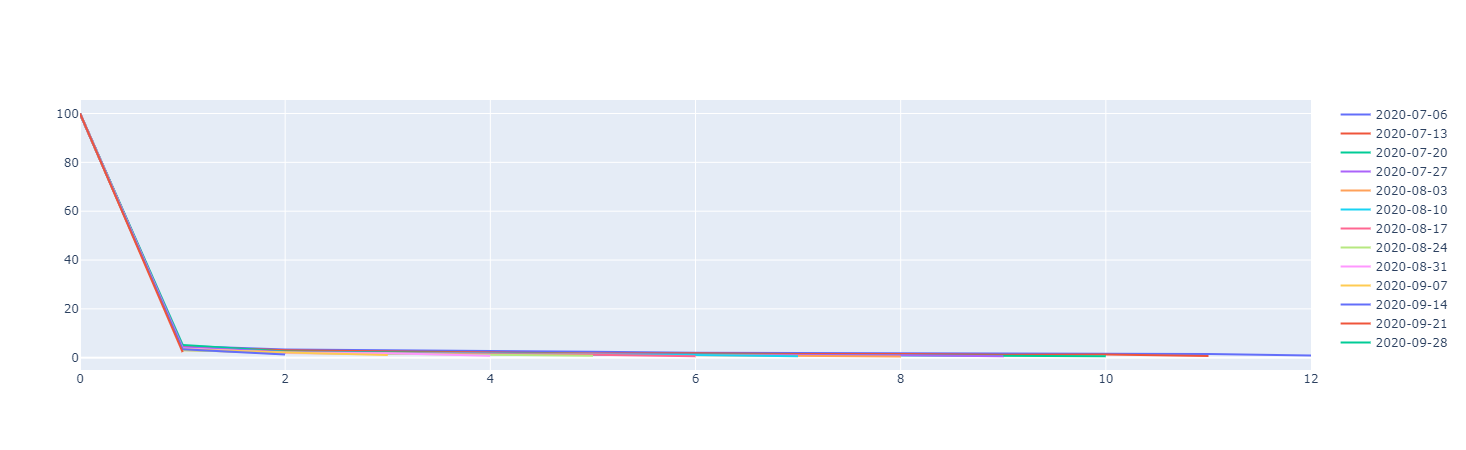

In [12]:
plotly_df(ret_df_norm)

In [13]:
ret_df_norm.T.fillna('').style.applymap(highlight_vals)

week_num,0,1,2,3,4,5,6,7,8,9,10,11,12
min_date,,,,,,,,,,,,,
2020-07-06,100,4.82226,3.38362,2.97856,2.71667,2.44081,2.07417,1.92751,1.82275,1.7599,1.57134,1.48753,0.865982
2020-07-13,100,4.53186,3.08166,2.56956,2.12091,1.71757,1.81728,1.49098,1.47739,1.21907,1.28252,0.693374,
2020-07-20,100,5.23314,2.57323,2.13979,1.86605,1.49649,1.30943,1.19993,1.0813,1.01287,0.597682,,
2020-07-27,100,4.27287,2.36455,1.89077,1.75477,1.36433,1.2415,1.10551,1.02215,0.565914,,,
2020-08-03,100,3.54744,2.14411,1.88184,1.55057,1.36652,1.09966,0.920217,0.492316,,,,
2020-08-10,100,3.31692,2.06599,1.64756,1.49501,1.19426,1.10709,0.584056,,,,,
2020-08-17,100,3.19268,1.92855,1.68694,1.40651,1.23824,0.638537,,,,,,
2020-08-24,100,3.08824,1.9928,1.55221,1.30967,0.836736,,,,,,,
2020-08-31,100,3.72771,1.91629,1.79235,0.848508,,,,,,,,


### Rolling retention


In [14]:
q = '''
SELECT
    uniq(client_id) as clients,
    min_date,
    week_num
FROM
    (SELECT 
        client_id,
        min_date, 
        arrayJoin(range(toUInt64((max_date - min_date)/7) + 1)) as week_num
    FROM
        (
            SELECT
                client_id,
                min(date) as min_date,
                max(date) as max_date
            FROM metrica_data.retention_users
            GROUP BY client_id
            HAVING (min_date <= '{end_date}') AND (min_date >= '{start_date}')
        ))
GROUP BY
    min_date,
    week_num
FORMAT TabSeparatedWithNames
'''.format(
    start_date = start_date.strftime('%Y-%m-%d'),
    end_date = end_date.strftime('%Y-%m-%d')
)

raw_roll_ret_df = my_client.get_clickhouse_df(q)

In [15]:
roll_ret_df = raw_roll_ret_df.pivot_table(index = 'min_date', 
                                          values = 'clients', 
                                          columns = 'week_num').fillna(0).T

In [16]:
roll_ret_df_norm = roll_ret_df.apply(lambda x: 100*x/roll_ret_df.loc[0], axis = 1).applymap(lambda x: x if x!=0 else None)

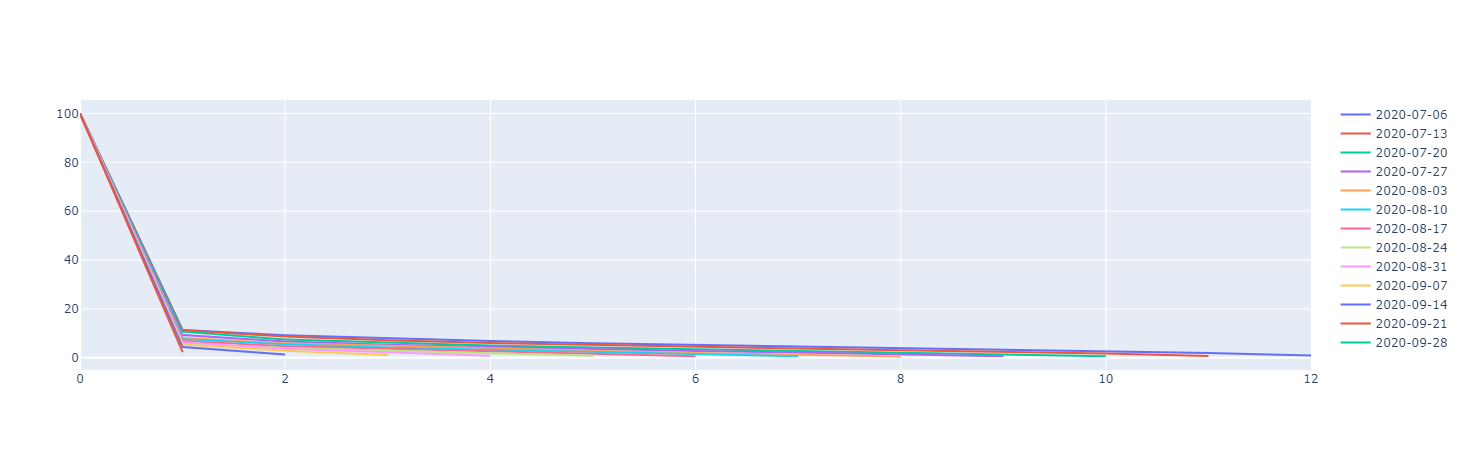

In [17]:
plotly_df(roll_ret_df_norm)

In [18]:
roll_ret_df_norm.T.fillna('').style.applymap(highlight_vals)

week_num,0,1,2,3,4,5,6,7,8,9,10,11,12
min_date,,,,,,,,,,,,,
2020-07-06,100,11.3486,9.16265,7.90558,6.80913,5.93617,5.25875,4.54641,3.87597,3.27886,2.62239,1.89259,0.865982
2020-07-13,100,11.239,8.67851,7.19659,6.04097,5.17991,4.4956,3.72972,3.07713,2.39282,1.71304,0.693374,
2020-07-20,100,10.6625,7.40487,6.10001,5.02783,4.17009,3.45378,2.81504,2.13067,1.4463,0.597682,,
2020-07-27,100,9.33099,6.62426,5.32573,4.36061,3.41303,2.73744,2.0794,1.34679,0.565914,,,
2020-08-03,100,8.07491,5.9262,4.80813,3.74068,2.80206,1.94166,1.21469,0.492316,,,,
2020-08-10,100,7.59709,5.46572,4.17121,3.22103,2.28392,1.47757,0.584056,,,,,
2020-08-17,100,6.81249,4.65528,3.5853,2.5714,1.65243,0.638537,,,,,,
2020-08-24,100,5.99458,3.94115,2.76891,1.81495,0.836736,,,,,,,
2020-08-31,100,6.34951,3.66575,2.34531,0.848508,,,,,,,,
